### Задание

1. Использовать датасет MovieLens.

2. Построить рекомендации (регрессия, предсказываем оценку) на фичах:

    - TF-IDF на тегах и жанрах

    - средние оценки (+ median, variance и т. д.) пользователя и фильма
    
3. Оценить RMSE на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import io, pickle, zipfile

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from zipfile import ZipFile

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

In [2]:
# посмотрим какие файлы есть в архиве 
with ZipFile('ml-latest-small.zip', 'r') as myzip:
    for item in myzip.infolist():
        print(f'File Name: {item.filename} ')

File Name: ml-latest-small/ 
File Name: ml-latest-small/links.csv 
File Name: ml-latest-small/tags.csv 
File Name: ml-latest-small/ratings.csv 
File Name: ml-latest-small/README.txt 
File Name: ml-latest-small/movies.csv 


In [3]:
# извлечение из архива
with ZipFile('ml-latest-small.zip', 'r') as myzip:
    myzip.extractall()

movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [8]:
movies_with_tags = movies.merge(tags, on='movieId')
del movies_with_tags['timestamp']
movies_with_tags

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,fun
3,2,Jumanji (1995),Adventure|Children|Fantasy,62,fantasy
4,2,Jumanji (1995),Adventure|Children|Fantasy,62,magic board game
...,...,...,...,...,...
3678,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,62,star wars
3679,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,anime
3680,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,comedy
3681,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,gintama


In [9]:
r_m_t = ratings.merge(movies_with_tags, how = 'left')
r_m_t

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,NaN,NaN,NaN
1,1,3,4.0,964981247,NaN,NaN,NaN
2,1,6,4.0,964982224,NaN,NaN,NaN
3,1,47,5.0,964983815,NaN,NaN,NaN
4,1,50,5.0,964982931,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,NaN,NaN,NaN
102673,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller,Heroic Bloodshed
102674,610,168250,5.0,1494273047,NaN,NaN,NaN
102675,610,168252,5.0,1493846352,NaN,NaN,NaN


In [10]:
# оставим только те строки, где присутствуют тэги
r_m_t = r_m_t.dropna()
r_m_t = r_m_t.reset_index(drop=True)
del r_m_t['timestamp']
r_m_t

,userId,movieId,rating,title,genres,tag
0,2,60756,5.0,Step Brothers (2008),Comedy,funny
1,2,60756,5.0,Step Brothers (2008),Comedy,Highly quotable
2,2,60756,5.0,Step Brothers (2008),Comedy,will ferrell
3,2,89774,5.0,Warrior (2011),Drama,Boxing story
4,2,89774,5.0,Warrior (2011),Drama,MMA
...,...,...,...,...,...,...
3471,606,6107,4.0,Night of the Shooting Stars (Notte di San Lore...,Drama|War,World War II
3472,606,7382,4.5,I'm Not Scared (Io non ho paura) (2003),Drama|Mystery|Thriller,for katie
3473,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,gun fu
3474,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,heroic bloodshed


In [11]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|')).lower()

In [12]:
movie_genres = [change_string(g) for g in r_m_t.genres.values]
movie_genres[:5]

['comedy', 'comedy', 'comedy', 'drama', 'drama']

In [13]:
r_m_t_genre = TfidfVectorizer()
genre_tfidf = r_m_t_genre.fit_transform(movie_genres)
genre_tfidf

<3476x20 sparse matrix of type '<class 'numpy.float64'>'
	with 9463 stored elements in Compressed Sparse Row format>

In [14]:
genre_ = pd.DataFrame(genre_tfidf.toarray(), columns=r_m_t_genre.get_feature_names_out())
genre_

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.352848,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.935681,0.0
3472,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.372715,0.0,0.0,0.0,0.0,0.0,0.765909,0.0,0.0,0.0,0.523896,0.000000,0.0
3473,0.561435,0.0,0.0,0.0,0.0,0.564029,0.0,0.351021,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.493402,0.000000,0.0
3474,0.561435,0.0,0.0,0.0,0.0,0.564029,0.0,0.351021,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.493402,0.000000,0.0


In [15]:
r_m_t_genre_tfidf = pd.concat([r_m_t, genre_], axis=1)
del r_m_t_genre_tfidf['genres']
r_m_t_genre_tfidf

,userId,movieId,rating,title,tag,action,adventure,animation,children,comedy,...,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,2,60756,5.0,Step Brothers (2008),funny,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2,60756,5.0,Step Brothers (2008),Highly quotable,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,2,60756,5.0,Step Brothers (2008),will ferrell,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,2,89774,5.0,Warrior (2011),Boxing story,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,2,89774,5.0,Warrior (2011),MMA,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,606,6107,4.0,Night of the Shooting Stars (Notte di San Lore...,World War II,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.935681,0.0
3472,606,7382,4.5,I'm Not Scared (Io non ho paura) (2003),for katie,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.765909,0.0,0.0,0.0,0.523896,0.000000,0.0
3473,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),gun fu,0.561435,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.493402,0.000000,0.0
3474,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),heroic bloodshed,0.561435,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.493402,0.000000,0.0


In [16]:
def change_tag(s):
    return str(s).replace(' ', '').replace('-', '').lower()

In [17]:
r_m_t_tags = [change_tag(t) for t in r_m_t.tag.values]
r_m_t_tags[:5]

['funny', 'highlyquotable', 'willferrell', 'boxingstory', 'mma']

In [18]:
r_m_t_tag = TfidfVectorizer()
r_m_t_tag_tfidf = r_m_t_tag.fit_transform(r_m_t_tags)
r_m_t_tag_tfidf

<3476x1436 sparse matrix of type '<class 'numpy.float64'>'
	with 3512 stored elements in Compressed Sparse Row format>

In [19]:
tag_ = pd.DataFrame(r_m_t_tag_tfidf.toarray(), columns=r_m_t_tag.get_feature_names_out())
tag_

,06oscarnominatedbestmovieanimation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001like,2danimation,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_ = pd.concat([r_m_t_genre_tfidf, tag_], axis=1)
X_

,userId,movieId,rating,title,tag,action,adventure,animation,children,comedy,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,2,60756,5.0,Step Brothers (2008),funny,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,60756,5.0,Step Brothers (2008),Highly quotable,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,60756,5.0,Step Brothers (2008),will ferrell,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,89774,5.0,Warrior (2011),Boxing story,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,89774,5.0,Warrior (2011),MMA,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,606,6107,4.0,Night of the Shooting Stars (Notte di San Lore...,World War II,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3472,606,7382,4.5,I'm Not Scared (Io non ho paura) (2003),for katie,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3473,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),gun fu,0.561435,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3474,610,3265,5.0,Hard-Boiled (Lat sau san taam) (1992),heroic bloodshed,0.561435,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def normalization (df, series):
    '''
    Функция принимает на вход df, столбец,
    нормализует значения столбца,
    добавляет результат нормализации,
    удаляет исходный столбец,
    выводит на печать df
    ''' 
    mins = df[series].min()
    maxs = df[series].max()
    df['norm_' + series] = (df[series] - mins) / (maxs - mins)
    del df[series] 
    display(df.head())  

In [22]:
normalization (X_, 'rating')

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating
0,2,60756,Step Brothers (2008),funny,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,60756,Step Brothers (2008),Highly quotable,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,60756,Step Brothers (2008),will ferrell,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,89774,Warrior (2011),Boxing story,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,89774,Warrior (2011),MMA,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
y = X_['norm_rating']
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2,
                                                    random_state=43, stratify=y)

In [24]:
X_train

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating
1066,474,551,"Nightmare Before Christmas, The (1993)",Christmas,0.000000,0.0,0.475608,0.505346,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556
1507,474,2295,"Impostors, The (1998)",Screwball,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
778,424,2700,"South Park: Bigger, Longer and Uncut (1999)",Trey Parker,0.000000,0.0,0.604907,0.000000,0.350071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
242,62,88405,Friends with Benefits (2011),romance,0.000000,0.0,0.000000,0.000000,0.610872,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
2060,474,6788,Angie (1994),pregnancy,0.000000,0.0,0.000000,0.000000,0.558716,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,599,296,Pulp Fiction (1994),motherfucker,0.000000,0.0,0.000000,0.000000,0.505700,0.588013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
118,62,27660,"Animatrix, The (2003)",sci-fi,0.456783,0.0,0.681946,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889
1457,474,2020,Dangerous Liaisons (1988),adultery,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778
1308,474,1278,Young Frankenstein (1974),spoof,0.000000,0.0,0.000000,0.000000,0.522071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778


In [25]:
# средний рейтинг, который выставляет пользователь
mean_rating_user_train = X_train.groupby('userId').agg({'norm_rating': ['mean']}). reset_index()
mean_rating_user_train.columns = ['userId', 'mean_rating_user']
mean_rating_user_train.head()

,userId,mean_rating_user
0,2,1.000000
1,18,0.825397
2,49,0.888889
3,62,0.773534
4,63,1.000000


In [26]:
# средний рейтинг, который выставляет пользователь
mean_rating_user_test = X_test.groupby('userId').agg({'norm_rating': ['mean']}). reset_index()
mean_rating_user_test.columns = ['userId', 'mean_rating_user']
mean_rating_user_test.head()

,userId,mean_rating_user
0,2,1.000000
1,7,0.111111
2,18,0.666667
3,21,0.000000
4,62,0.730352


In [27]:
normalization(mean_rating_user_train, 'mean_rating_user')

,userId,norm_mean_rating_user
0,2,1.000000
1,18,0.714286
2,49,0.818182
3,62,0.629419
4,63,1.000000


In [28]:
normalization(mean_rating_user_test, 'mean_rating_user')

,userId,norm_mean_rating_user
0,2,1.000000
1,7,0.111111
2,18,0.666667
3,21,0.000000
4,62,0.730352


In [29]:
# средний рейтинг пользователей добавим как признак в train
X_train = X_train.join(mean_rating_user_train.set_index('userId'), on='userId')
X_train

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating,norm_mean_rating_user
1066,474,551,"Nightmare Before Christmas, The (1993)",Christmas,0.000000,0.0,0.475608,0.505346,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.525882
1507,474,2295,"Impostors, The (1998)",Screwball,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.525882
778,424,2700,"South Park: Bigger, Longer and Uncut (1999)",Trey Parker,0.000000,0.0,0.604907,0.000000,0.350071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.648485
242,62,88405,Friends with Benefits (2011),romance,0.000000,0.0,0.000000,0.000000,0.610872,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.629419
2060,474,6788,Angie (1994),pregnancy,0.000000,0.0,0.000000,0.000000,0.558716,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.525882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,599,296,Pulp Fiction (1994),motherfucker,0.000000,0.0,0.000000,0.000000,0.505700,0.588013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
118,62,27660,"Animatrix, The (2003)",sci-fi,0.456783,0.0,0.681946,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.629419
1457,474,2020,Dangerous Liaisons (1988),adultery,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.525882
1308,474,1278,Young Frankenstein (1974),spoof,0.000000,0.0,0.000000,0.000000,0.522071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.525882


In [30]:
# средний рейтинг пользователей добавим как признак в test
X_test = X_test.join(mean_rating_user_test.set_index('userId'), on='userId')
X_test

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating,norm_mean_rating_user
3286,599,296,Pulp Fiction (1994),neo-noir,0.000000,0.000000,0.0,0.000000,0.505700,0.588013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
198,62,60074,Hancock (2008),Charlize Theron,0.408024,0.457743,0.0,0.000000,0.352528,0.409909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.730352
2188,474,8266,Purple Rain (1984),Prince,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.716475
1957,474,6181,"Red Badge of Courage, The (1951)",Civil War,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.716475
2551,477,68791,Terminator Salvation (2009),franchise,0.487727,0.547158,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.859829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,474,944,Lost Horizon (1937),Shangri-La,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.716475
502,184,4226,Memento (2000),dark,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.833333
933,474,34,Babe (1995),Animal movie,0.000000,0.000000,0.0,0.930344,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.716475
3433,599,2959,Fight Club (1999),disturbing,0.561435,0.000000,0.0,0.000000,0.000000,0.564029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


In [31]:
# средний рейтинг фильма train
mean_rating_film_train = X_train.groupby('movieId').agg({'norm_rating': ['mean']}). reset_index()
mean_rating_film_train.columns = ['movieId', 'norm_mean_rating_film']
mean_rating_film_train

,movieId,norm_mean_rating_film
0,1,0.722222
1,2,0.666667
2,3,0.444444
3,5,0.222222
4,7,0.555556
...,...,...
1261,183611,0.777778
1262,184471,0.666667
1263,187593,0.777778
1264,187595,0.777778


In [32]:
# средний рейтинг фильма test
mean_rating_film_test = X_test.groupby('movieId').agg({'norm_rating': ['mean']}). reset_index()
mean_rating_film_test.columns = ['movieId', 'norm_mean_rating_film']
mean_rating_film_test

,movieId,norm_mean_rating_film
0,1,0.777778
1,2,0.777778
2,3,0.444444
3,26,0.666667
4,31,0.555556
...,...,...
469,176419,0.555556
470,179401,0.666667
471,183611,0.777778
472,184471,0.666667


In [33]:
# средний рейтинг фильма добавим как признак в train
X_train = X_train.join(mean_rating_film_train.set_index('movieId'), on='movieId')
X_train

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating,norm_mean_rating_user,norm_mean_rating_film
1066,474,551,"Nightmare Before Christmas, The (1993)",Christmas,0.000000,0.0,0.475608,0.505346,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.525882,0.555556
1507,474,2295,"Impostors, The (1998)",Screwball,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.525882,1.000000
778,424,2700,"South Park: Bigger, Longer and Uncut (1999)",Trey Parker,0.000000,0.0,0.604907,0.000000,0.350071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.648485,1.000000
242,62,88405,Friends with Benefits (2011),romance,0.000000,0.0,0.000000,0.000000,0.610872,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.629419,0.666667
2060,474,6788,Angie (1994),pregnancy,0.000000,0.0,0.000000,0.000000,0.558716,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.525882,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,599,296,Pulp Fiction (1994),motherfucker,0.000000,0.0,0.000000,0.000000,0.505700,0.588013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.996296
118,62,27660,"Animatrix, The (2003)",sci-fi,0.456783,0.0,0.681946,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.629419,0.888889
1457,474,2020,Dangerous Liaisons (1988),adultery,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.525882,0.777778
1308,474,1278,Young Frankenstein (1974),spoof,0.000000,0.0,0.000000,0.000000,0.522071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.525882,0.777778


In [34]:
# средний рейтинг фильма добавим как признак в test
X_test = X_test.join(mean_rating_film_test.set_index('movieId'), on='movieId')
X_test

,userId,movieId,title,tag,action,adventure,animation,children,comedy,crime,...,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_rating,norm_mean_rating_user,norm_mean_rating_film
3286,599,296,Pulp Fiction (1994),neo-noir,0.000000,0.000000,0.0,0.000000,0.505700,0.588013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.996416
198,62,60074,Hancock (2008),Charlize Theron,0.408024,0.457743,0.0,0.000000,0.352528,0.409909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.730352,0.555556
2188,474,8266,Purple Rain (1984),Prince,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.716475,0.444444
1957,474,6181,"Red Badge of Courage, The (1951)",Civil War,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.716475,0.777778
2551,477,68791,Terminator Salvation (2009),franchise,0.487727,0.547158,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.859829,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,474,944,Lost Horizon (1937),Shangri-La,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.716475,0.777778
502,184,4226,Memento (2000),dark,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.833333,0.888889
933,474,34,Babe (1995),Animal movie,0.000000,0.000000,0.0,0.930344,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.716475,0.888889
3433,599,2959,Fight Club (1999),disturbing,0.561435,0.000000,0.0,0.000000,0.000000,0.564029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000


In [35]:
X_train.drop(['userId', 'movieId', 'title', 'tag', 'norm_rating'], axis= 1 , inplace= True)
X_test.drop(['userId', 'movieId', 'title', 'tag', 'norm_rating'], axis= 1 , inplace= True)

In [36]:
X_train

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,...,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel,norm_mean_rating_user,norm_mean_rating_film
1066,0.000000,0.0,0.475608,0.505346,0.000000,0.000000,0.0,0.000000,0.449662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525882,0.555556
1507,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525882,1.000000
778,0.000000,0.0,0.604907,0.000000,0.350071,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.648485,1.000000
242,0.000000,0.0,0.000000,0.000000,0.610872,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.629419,0.666667
2060,0.000000,0.0,0.000000,0.000000,0.558716,0.000000,0.0,0.404312,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525882,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,0.000000,0.0,0.000000,0.000000,0.505700,0.588013,0.0,0.365948,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.996296
118,0.456783,0.0,0.681946,0.000000,0.000000,0.000000,0.0,0.285590,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.629419,0.888889
1457,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.487500,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525882,0.777778
1308,0.000000,0.0,0.000000,0.000000,0.522071,0.000000,0.0,0.000000,0.852902,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525882,0.777778


In [37]:
model = LinearRegression()

model = model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse_linreg = mean_squared_error(y_test, predictions, squared=False)
print('RMSE:' , rmse_linreg)

RMSE: 1652273934572.5613


#### По величине RMSE видно, что модель неадекватна. Предполагаю, что слишком много признаков

In [38]:
# попробую регрессию дерева решений
from sklearn.tree import DecisionTreeRegressor

In [39]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
predictions_tree = model.predict(X_test)
rmse_dtr = mean_squared_error(y_test, predictions_tree, squared=False)
print('RMSE:' , rmse_dtr)

RMSE: 0.056613088388506344


#### По величине RMSE видно, что модель успешно отработала.

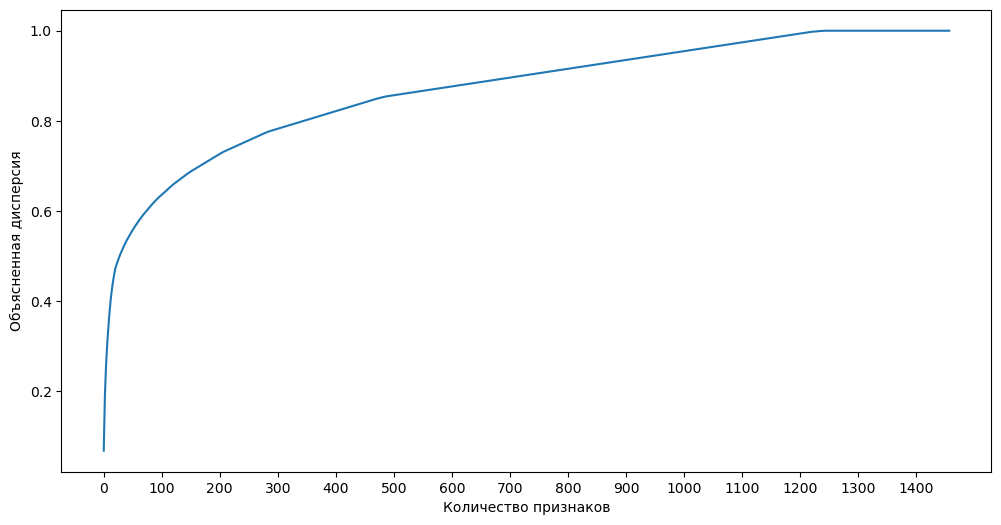

In [40]:
# Учитывая неудовлетворительный результат модели линейной регрессии,
# попробую сократить размерность признаков с помощью
# Метода главных компонент


from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Устанавливаем размер фигуры

pca = PCA().fit(X_train)
n_components = pca.explained_variance_ratio_.shape[0]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, n_components + 1, step=100))  # Устанавливаем шаг на оси X
plt.xlabel('Количество признаков')
plt.ylabel('Объясненная дисперсия')
plt.show()

In [41]:
# Установим важные компоненты:
components = 400

# Применим преобразование метода главных компонент 
# к данным, уменьшая их размерность до количества компонент == components

pca = PCA(n_components=components)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

# Вычисление дисперсии, объясненной главными компонентами
# print("Дисперсия каждой компоненты: ", pca.explained_variance_ratio_)
print("\n Общая объясненная дисперсия: ",
      round(sum(list(pca.explained_variance_ratio_)) * 100, 2))


 Общая объясненная дисперсия:  93.98


In [42]:
# Названия столбцов после применения PCA
pca_cols = []
for i in range(components):
    pca_cols.append(f"PC_{i}")
# print(pca_cols)

# Создание DataFrame
pca_train = pd.DataFrame(X_pca_train, columns=pca_cols)
pca_test = pd.DataFrame(X_pca_test, columns=pca_cols)


In [43]:
model = LinearRegression()

model_pca = model.fit(pca_train, y_train)
predictions_pca = model.predict(pca_test)
rmse_linreg_pca = mean_squared_error(y_test, predictions_pca, squared=False)
print('RMSE:' , rmse_linreg_pca)

RMSE: 0.3036158729368245


In [44]:
tree_pca = DecisionTreeRegressor(max_depth=6)
tree_pca.fit(pca_train, y_train)
predictions_tree_pca = tree_pca.predict(pca_test)
rmse_dtr_pca = mean_squared_error(y_test, predictions_tree_pca, squared=False)
print('RMSE:' , rmse_dtr_pca)

RMSE: 0.2687344342273687


In [45]:
RMSE = pd.DataFrame({'LinReg': rmse_linreg,
 'Linreg_PCA': rmse_linreg_pca,
 'DTR': rmse_dtr,
 'DTR_PCA': rmse_dtr_pca}, index=[0])

In [46]:
RMSE

,LinReg,Linreg_PCA,DTR,DTR_PCA
0,1.652274e+12,0.303616,0.056613,0.268734


Метод главных компонент помог исправить положение с моделью

линейной регрессии. Однако, ухудшил результат модели Дерева решений.

Самая эффективная модель - DecisionTreeRegressor, без применения метода PCA